# Imports

In [1]:
# Importing the Keras libraries and packages

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

train_dir = "D:/Drone/data"
eval_dir = train_dir

# Load and split the data

In [2]:
# Helper function to load images from the given directory
def load_images(directory):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            image = cv2.resize(cv2.imread(filepath), (64, 64))
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [3]:
uniq_labels = sorted(os.listdir(train_dir))
images, labels = load_images(directory=train_dir)

# Splitting the data into train, test, and eval
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.1, stratify=labels
)

X_train, X_eval, y_train, y_eval = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train
)

In [4]:
n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)

print("Total number of symbols: ", n)
print("Number of training images: ", train_n)
print("Number of testing images: ", test_n)

eval_n = len(X_eval)
print("Number of evaluation images: ", eval_n)

Total number of symbols:  6
Number of training images:  7430
Number of testing images:  1033
Number of evaluation images:  1858


In [5]:
uniq_labels

['blank', 'fist', 'five', 'ok', 'thumbsdown', 'thumbsup']

In [6]:
import keras

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_eval = keras.utils.to_categorical(y_eval)

In [7]:
print(y_train[0])
print(len(y_train[0]))

[1. 0. 0. 0. 0. 0.]
6


# Normalize the data

In [8]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

# ResNet

In [9]:
#Initialising ResNet 
classifier_resnet = ResNet50(input_shape= (64,64,3),include_top=False,weights='imagenet')

In [13]:
#don't train existing weights for resnet50
for layer in classifier_resnet.layers:
    layer.trainable = False

In [14]:
classifier2 = classifier_resnet.output#head mode
classifier2 = Flatten()(classifier2)#adding layer of flatten
classifier2 = Dropout(0.6)(classifier2)
classifier2 = Dense(units=6, activation='softmax')(classifier2)

model2 = Model(inputs = classifier_resnet.input , outputs = classifier2)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [16]:
#fit the model
#it will take some time to train
history2 = model2.fit(X_train, y_train, epochs=50,batch_size = 64,validation_data=(X_eval, y_eval))

Epoch 1/50


117/117 [==============================] - 62s 398ms/step - loss: 0.7563 - accuracy: 0.7480 - val_loss: 0.3052 - val_accuracy: 0.9623
Epoch 2/50
117/117 [==============================] - 24s 208ms/step - loss: 0.3157 - accuracy: 0.9144 - val_loss: 0.1736 - val_accuracy: 0.9801
Epoch 3/50
117/117 [==============================] - 24s 205ms/step - loss: 0.2347 - accuracy: 0.9363 - val_loss: 0.1265 - val_accuracy: 0.9871
Epoch 4/50
117/117 [==============================] - 24s 205ms/step - loss: 0.1950 - accuracy: 0.9445 - val_loss: 0.1009 - val_accuracy: 0.9876
Epoch 5/50
117/117 [==============================] - 24s 207ms/step - loss: 0.1735 - accuracy: 0.9497 - val_loss: 0.0874 - val_accuracy: 0.9892
Epoch 6/50
117/117 [==============================] - 24s 204ms/step - loss: 0.1586 - accuracy: 0.9544 - val_loss: 0.0750 - val_accuracy: 0.9898
Epoch 7/50
117/117 [==============================] - 24s 203ms/step - loss: 0.1462 - accuracy: 0.9560 - val_loss: 0.0669 - val_

In [17]:
# Saving the model of resnet
model2.save('model_resnet_segmentation01.h5')

C:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
score = model2.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model2.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 99.806 %
Accuracy for evaluation images: 99.892 %


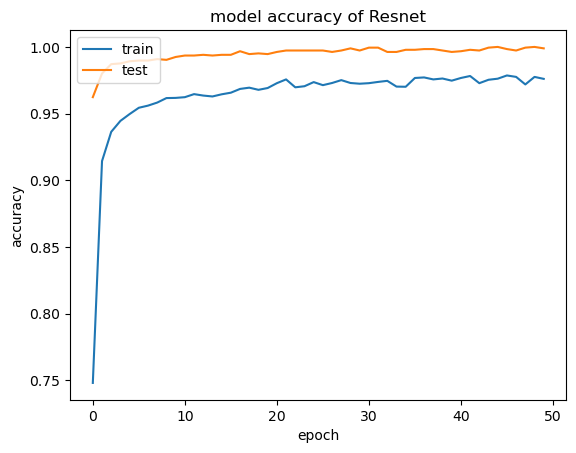

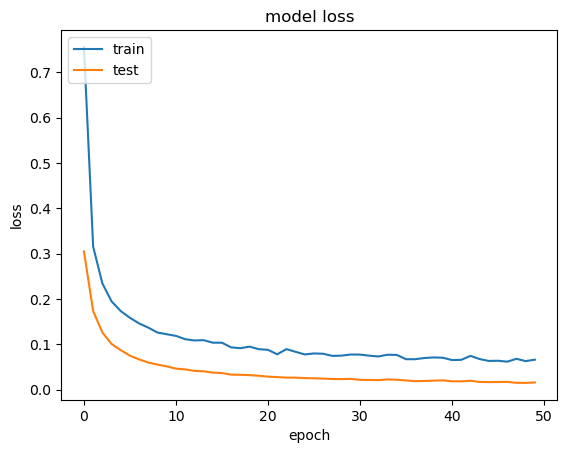

In [19]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy of Resnet')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

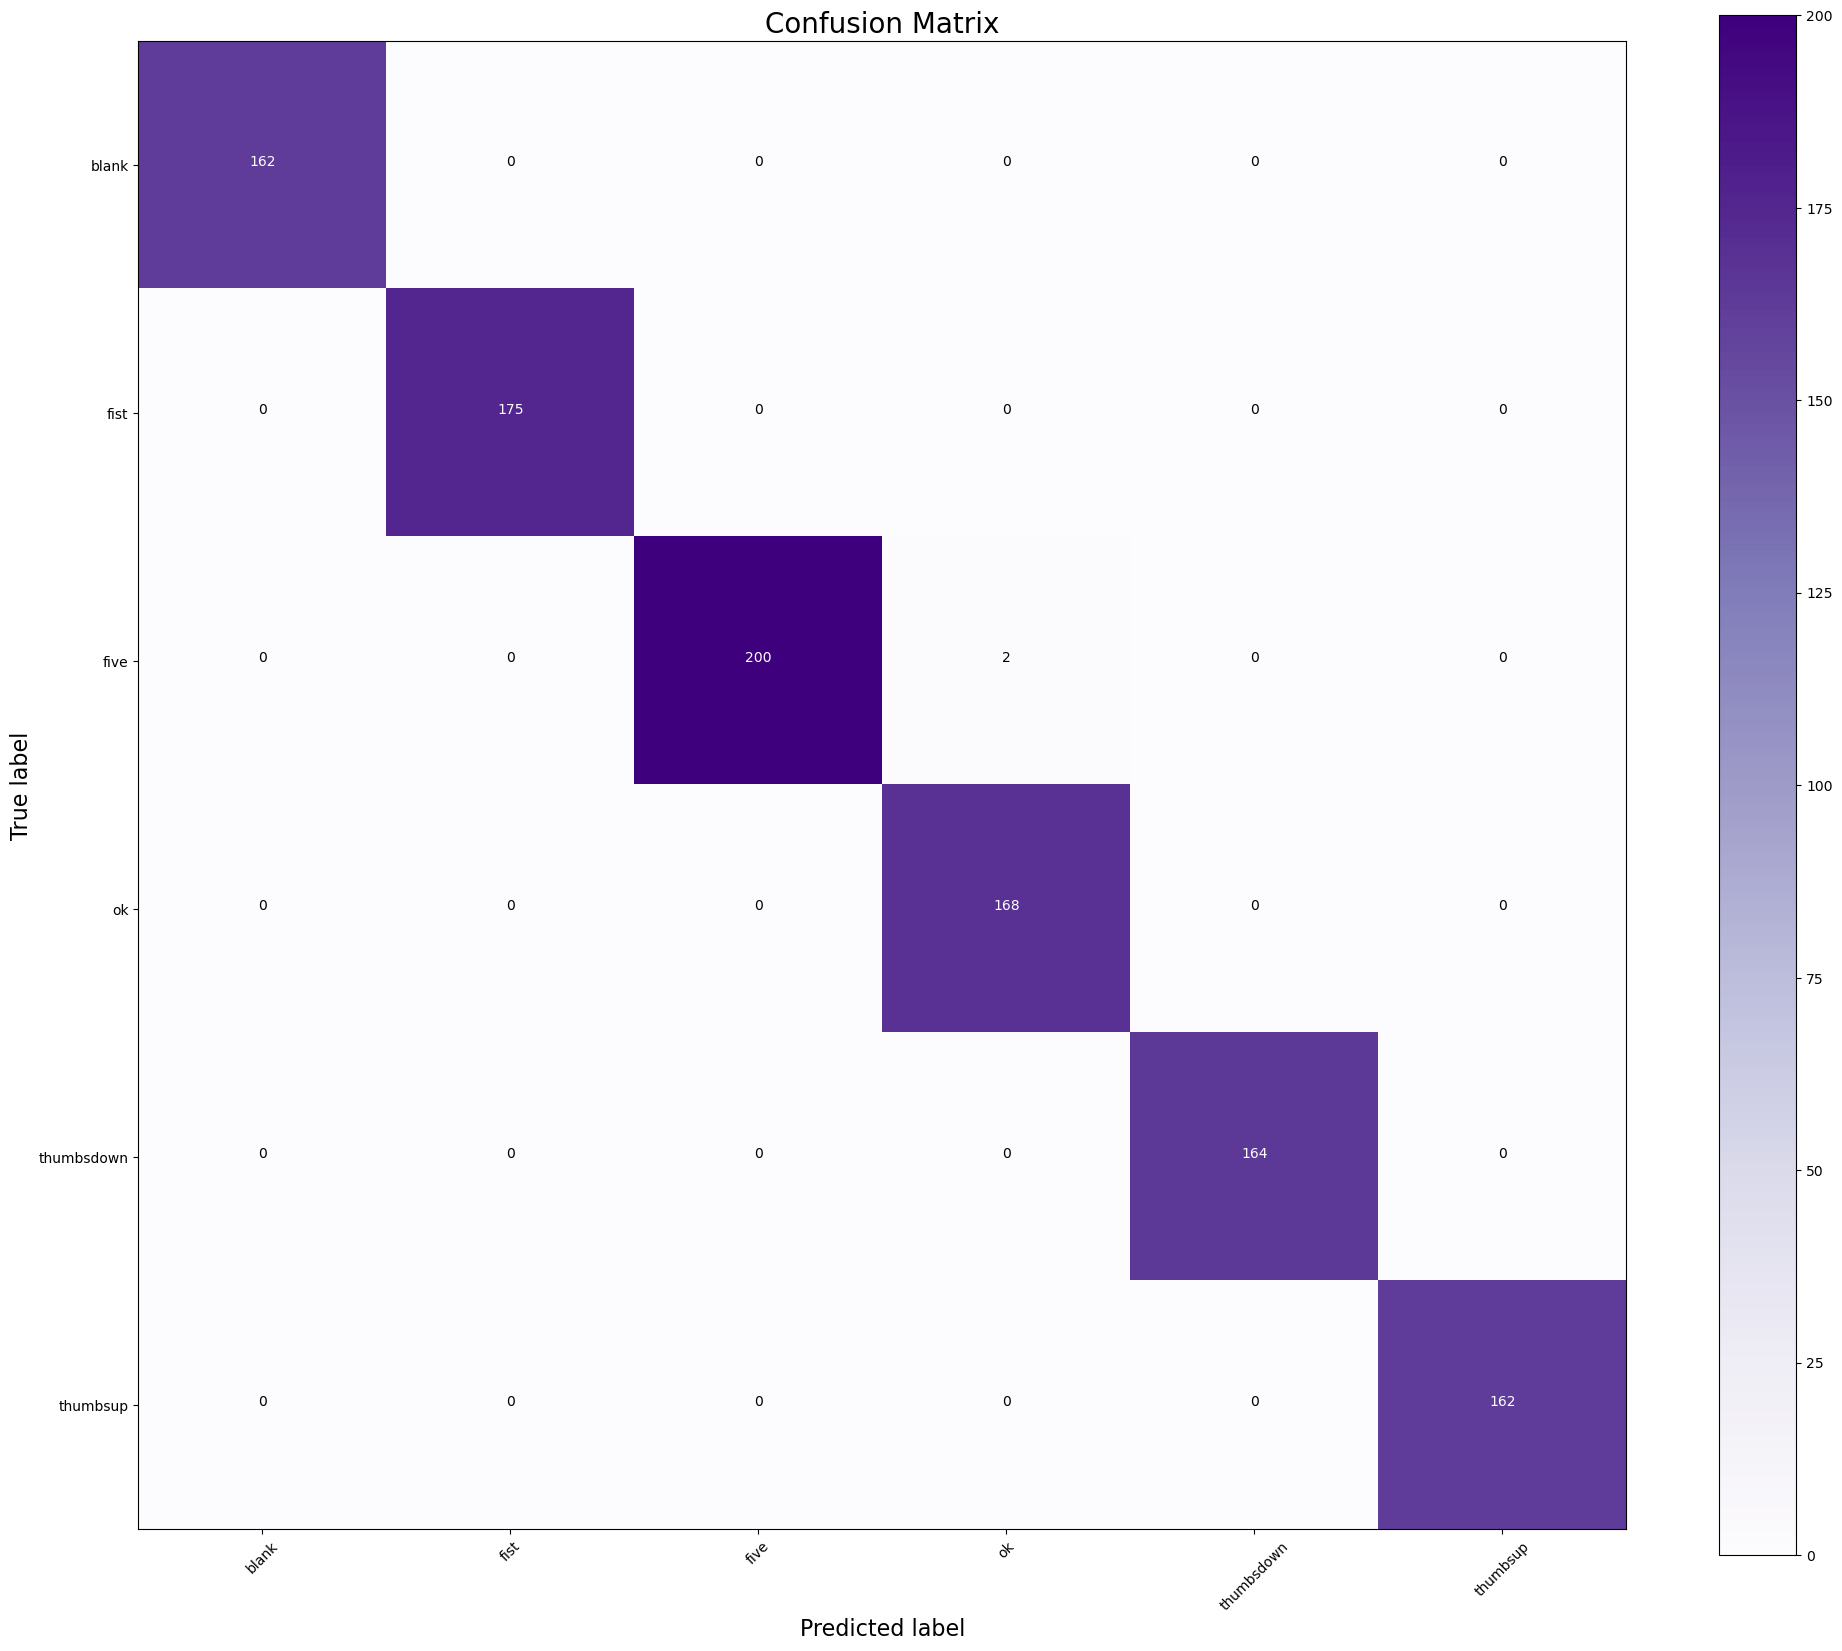

In [20]:
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model2.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

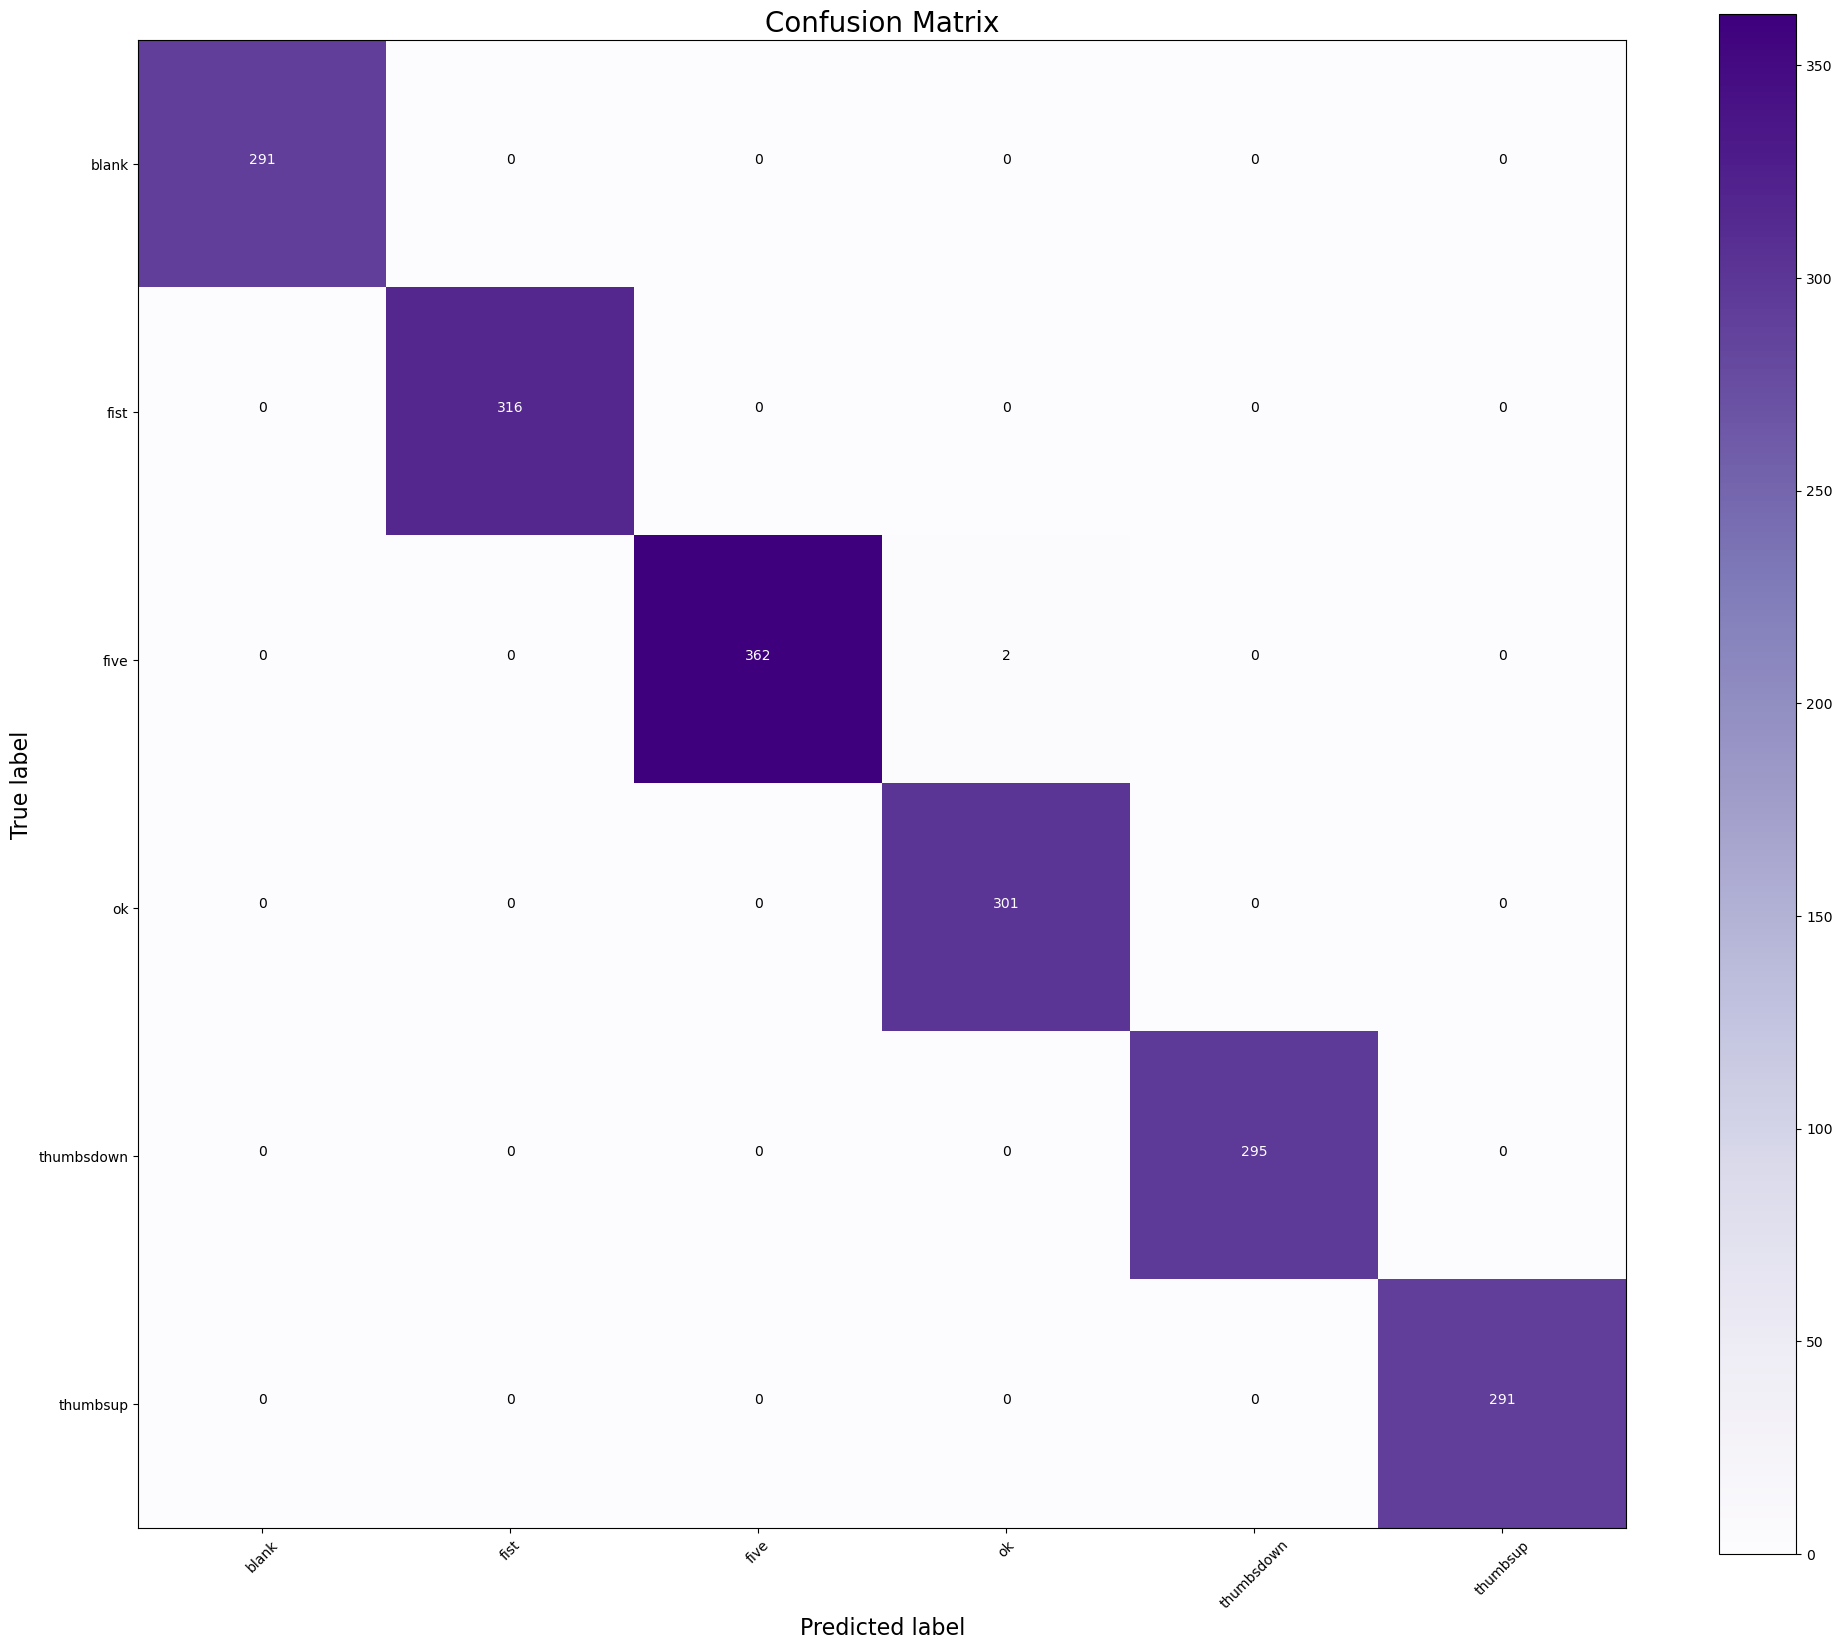

In [21]:
y_eval_pred = model2.predict(X_eval, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

1/1 [==============================] - 0s 72ms/step
blank


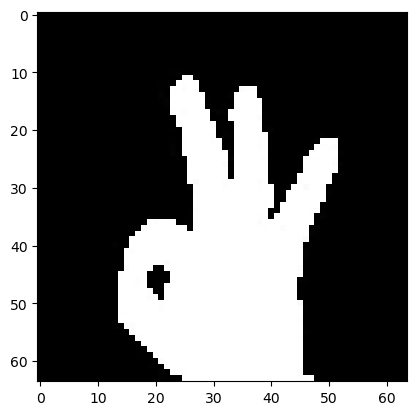

In [25]:
# for only one prediction
import numpy as np
from keras.preprocessing import image
test_image = image.load_img("D:/Drone/data/ok/ok3.jpg",target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model2.predict(test_image)

if result[0][0] == 1:
    prediction = 'blank'
elif result[0][1] == 1:
    prediction = 'fist'
elif result[0][2] == 1:
    prediction = 'five'
elif result[0][3] == 1:
    prediction = 'ok'
elif result[0][4] == 1:
    prediction = 'thumbsdown'
elif result[0][5] == 1:
    prediction = 'thumbsup'
else:
    prediction = ' NO '
    
print(prediction)

1/1 [==============================] - 2s 2s/step
Predicted class: blank


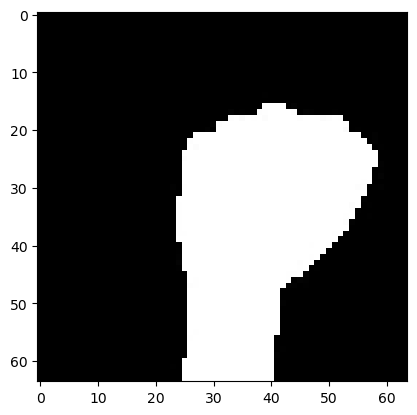

In [40]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model

def predict_image_class(image_path, model_path):
    # Load the model
    model = load_model(model_path)
    
    test_image = image.load_img(image_path, target_size=(64, 64))
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    result = model.predict(test_image)

    class_labels = ['blank', 'fist', 'five', 'ok', 'thumbsdown', 'thumbsup']
    predicted_class_index = np.argmax(result, axis=1)[0]  # Get the index of the maximum value in the array
    predicted_class = class_labels[predicted_class_index]

    return predicted_class

image_path = "D:/Drone/data/fist/fistq3.jpg"
model_path = "model_resnet_segmentation01.h5"
prediction = predict_image_class(image_path, model_path)
print("Predicted class:", prediction)
